# NLP project - Sex prediction in a register - 1ere Partie

In [1]:
### Importation des librairies utiles

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import Normalizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, accuracy_score

from sklearn.linear_model import RidgeClassifier

from transformers import pipeline, AutoModelForSequenceClassification, AutoTokenizer

import warnings
warnings.filterwarnings('ignore')


## Encodage des séquences

In [2]:
trans = pd.read_pickle('../Data/trans.pkl')
clean = pd.read_pickle('../Data/clean.pkl').replace(pd.NA, "")

trans.replace('ambigu', pd.NA, inplace=True)
trans.dropna(inplace=True)
trans.index = range(trans.shape[0])

ground = clean[[col for col in clean.columns if col[:6]=="ground"]]
pred = clean[[col for col in clean.columns if col[:4]=="pred"]]

In [3]:
ground.head(7)

,ground_civil_status,ground_occupation,ground_firstname,ground_link
0,,idem,marie,fille
1,,sp,louis-jean,chef
2,,idem,marie,idem
3,,,marie,femme
4,,,marguerite,
5,,metayer patron,antoine,chef de menage
6,,,louis,idem


In [4]:
def get_sentence_ground(row):
    stat, occup, name, link = row
    statut = " statut social : " + stat + "," if len(stat)>3 else ""
    metier = " metier : " + occup  + "," if len(occup)>3 else ""
    lien = " lien : " + link if len(link)>3 else ""
    return f"prénom : {name}," + statut + metier + lien

In [5]:
ground_sentences = ground.apply(get_sentence_ground, axis=1)


In [6]:
def trans_row(row: pd.Series):
    seq, lab, sco = row
    lab2 = ['homme', 'femme', 'inconnu']
    try:
        lab[lab.index('indéterminé')] = 'inconnu'
    except:
        pass
    dic = dict()
    for l in lab2:
        dic[l]=sco[lab.index(l)]
    return dic

def from_results(res):
    df = pd.DataFrame(res)
    return pd.DataFrame(df.apply(trans_row, axis=1).tolist())

def process(word):
    return 'indéterminé' if len(word)<3 else word

# df_results = from_results(results)


In [7]:
def bert_on_serie(ser, classifier, col_prefix, verbose=False):
    labels = ["femme", "homme", "indéterminé"]

    sequences = ser.apply(process).tolist()
    # print(*sequences, sep='\n')

    results = classifier(sequences, labels)

    if verbose:
        for i, result in enumerate(results):

            print(f"Phrase : {sequences[i]}")
            print("Labels prédits :")
            
            for label, score in zip(result["labels"], result["scores"]):
                print(f"- {label}: {score:.4f}")
            print()

    fro = from_results(results)
    fro.columns = col_prefix + fro.columns    
    return fro
    

In [8]:
# Charger le modèle et le tokenizer BERT
model_name = "facebook/bart-large-mnli"
model = AutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

#on choisit d'utiliser un classifieur zero-shot
classifier = pipeline("zero-shot-classification", model=model, tokenizer=tokenizer)


In [9]:
# Chaines brutes
df_groundtruth = bert_on_serie(trans.groundtruth, classifier, col_prefix="ground_", verbose=True)
df_prediction = bert_on_serie(trans.prediction, classifier, col_prefix="predi_", verbose=False)

# # Chaine traitée
df_groundsentences = bert_on_serie(ground_sentences, classifier, col_prefix="groundsentences_", verbose=False)

# # Chaines séparées - groundtruth
df_occupation = bert_on_serie(clean.ground_occupation, classifier, col_prefix="occup_", verbose=False)
df_link = bert_on_serie(clean.ground_link, classifier, col_prefix="link_")

# # Chaines séparées - prediction
df_profession = bert_on_serie(clean.pred_profession, classifier, col_prefix="profession_")
df_relation = bert_on_serie(clean.pred_relation, classifier, col_prefix="relation_")

Phrase : surname: chardon firstname: marie occupation: idem link: fille age: 30 
Labels prédits :
- femme: 0.9354
- homme: 0.0586
- indéterminé: 0.0060

Phrase : surname: lhopital firstname: louis-jean occupation: sp link: chef age: 67 
Labels prédits :
- homme: 0.8857
- femme: 0.0744
- indéterminé: 0.0399

Phrase : surname: papin firstname: marie occupation: idem link: idem employer: idem age: 15 
Labels prédits :
- femme: 0.8833
- homme: 0.1011
- indéterminé: 0.0156

Phrase : surname: lavocat firstname: marie link: femme birth_date: 1875 lob: rigny 
Labels prédits :
- femme: 0.9941
- homme: 0.0040
- indéterminé: 0.0019

Phrase : surname: benne firstname: marguerite age: 78 
Labels prédits :
- femme: 0.9597
- homme: 0.0228
- indéterminé: 0.0176

Phrase : surname: roy firstname: antoine occupation: metayer patron link: chef de menage age: 51 ans 
Labels prédits :
- femme: 0.5377
- homme: 0.4261
- indéterminé: 0.0362

Phrase : surname: bizet firstname: louis link: idem age: 9 
Labels pr

In [70]:
df_groundsentences.columns[df_groundsentences.apply(lambda row: row.argmax(), axis=1)].value_counts()

occup_femme      121
occup_homme       87
occup_inconnu     24
dtype: int64

## Classification et évaluation des modèles

In [82]:
### Score de classification brut à partir des scores zero-shot
y_pred = df_groundsentences.apply(np.argmax, axis=1)
y_true = (trans.sex=='femme').apply(int)
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.66      0.78       125
           1       0.84      0.95      0.89       107
           2       0.00      0.00      0.00         0

    accuracy                           0.80       232
   macro avg       0.60      0.54      0.56       232
weighted avg       0.90      0.80      0.83       232



In [189]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import cross_val_score, cross_val_predict, cross_validate


y = (trans.sex == 'homme').apply(int)
# X = df_link.join(df_occupation).join(df_groundsentences)
X = df_groundsentences.join(df_prediction)


models = [SVC(), RandomForestClassifier(), RidgeClassifier(), GaussianProcessClassifier()]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8 )
for model in models:
    print("¤"*60)
    model.fit(X_train, y_train)
    predi = model.predict(X_test)
    print(classification_report(y_test, predi))
print("¤"*60)


¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤
              precision    recall  f1-score   support

           0       0.91      0.93      0.92        91
           1       0.94      0.92      0.93        95

    accuracy                           0.92       186
   macro avg       0.92      0.92      0.92       186
weighted avg       0.92      0.92      0.92       186

¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤
              precision    recall  f1-score   support

           0       0.93      0.89      0.91        91
           1       0.90      0.94      0.92        95

    accuracy                           0.91       186
   macro avg       0.92      0.91      0.91       186
weighted avg       0.91      0.91      0.91       186

¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤
              precision    recall  f1-score   support

           0       0.93      0.89      0.91        91
           1       0.90      0.94      0.92        95


In [44]:
for nestim in [1,5,10,20,50, 100, 200]:
    cross = cross_val_score(RandomForestClassifier(nestim, max_depth=10), X, y, cv = 3)
    mean = np.array(cross).mean()
    print(nestim, ' :\t', cross, mean)


1  :	 [0.87179487 0.84415584 0.93506494] 0.8836718836718837
5  :	 [0.84615385 0.90909091 0.93506494] 0.8967698967698968
10  :	 [0.83333333 0.92207792 0.93506494] 0.8968253968253967
20  :	 [0.84615385 0.92207792 0.93506494] 0.901098901098901
50  :	 [0.84615385 0.92207792 0.93506494] 0.901098901098901
100  :	 [0.85897436 0.92207792 0.93506494] 0.9053724053724053
200  :	 [0.88461538 0.92207792 0.93506494] 0.9139194139194139


In [179]:
### Modèles à tester
models = [
    SVC(),
    RandomForestClassifier(n_estimators=100, max_depth=20),
    RidgeClassifier(),
    GaussianProcessClassifier(),
    LinearSVC()
]

model_names = [
    "SVC",
    "RandomForestClassifier",
    "RidgeClassifier",
    "GaussianProcessClassifier",
    "LinearSVC"
    ]

### Dataframes à tester
df_list = [
    df_groundsentences,
    df_groundtruth.join(df_groundsentences).join(df_prediction).join(df_link).join(df_occupation),
    df_prediction.join(df_groundsentences),
    df_occupation.join(df_groundsentences),
    df_link.join(df_groundsentences)
]

df_names = [
    "groundsentences",
    "groundtruth + groundsentences",
    "prediction + groundsentences",
    "occupation + groundsentences",
    "link + groundsentences"
]

# df_list = [
#     df_groundsentences,
#     df_groundtruth,
#     df_prediction,
#     df_occupation,
#     df_link
# ]

# df_names = [
#     "groundsentences",
#     "groundtruth",
#     "prediction",
#     "occupation",
#     "links"
# ]

# mods, dfs = np.meshgrid(models, df_list)

results = np.zeros((len(models), len(df_list)))

for i,mo in enumerate(models):
    print(mo)
    for j, df in enumerate(df_list):
        cro = cross_val_score(mo, df, y, cv=4).mean()
        results[i,j] = cro
        print(cro) 



SVC()
0.9051724137931034
0.9482758620689655
0.9267241379310345
0.918103448275862
0.9137931034482758
RandomForestClassifier(max_depth=20)
0.896551724137931
0.9137931034482759
0.9224137931034482
0.9008620689655172
0.896551724137931
RidgeClassifier()
0.9051724137931034
0.9310344827586207
0.9094827586206896
0.9094827586206896
0.9008620689655172
GaussianProcessClassifier()
0.9051724137931034
0.9267241379310345
0.9310344827586208
0.9137931034482759
0.9008620689655172
LinearSVC()
0.9051724137931034
0.9310344827586207
0.9310344827586208
0.9137931034482758
0.9051724137931034


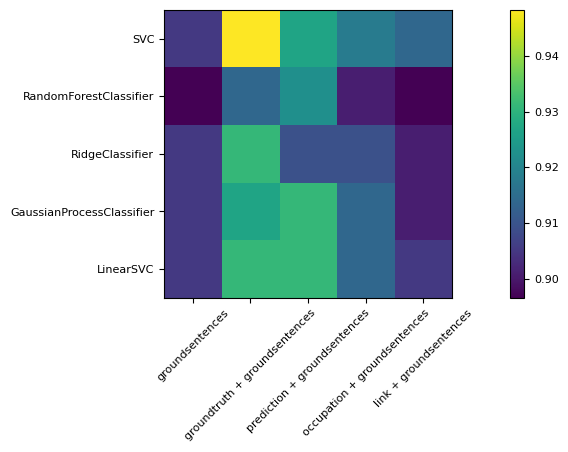

In [180]:
plt.figure()
plt.rcParams.update({'font.size': 8})

plt.imshow(results)
plt.xticks(range(5), df_names, rotation=45)
plt.yticks(range(5), model_names, rotation=0)
plt.subplots_adjust(left=-0.7, right=1.1, top=0.9, bottom=0.3)  # Réglez les valeurs des marges selon vos besoins
plt.colorbar()
# plt.savefig('classifiers_on_simple_datasets.png', facecolor='w', )
plt.show()

In [113]:
# 1 ligne = 1 model
# 1 colonne = 1 df
results

array([[0.90517241, 0.92241379, 0.92672414, 0.91810345, 0.9137931 ],
       [0.90086207, 0.9137931 , 0.91810345, 0.89224138, 0.90086207],
       [0.90517241, 0.90517241, 0.90948276, 0.90948276, 0.90086207],
       [0.90517241, 0.92241379, 0.93103448, 0.9137931 , 0.90086207],
       [0.90517241, 0.92241379, 0.93103448, 0.9137931 , 0.90517241]])